In [32]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools

# ML and statistics libraries
import scipy.stats as stats
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [10,6]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("darkgrid")
sns.set_palette(sns.light_palette("navy", n_colors=10, reverse=True))

In [2]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Distribution of Target Variable:

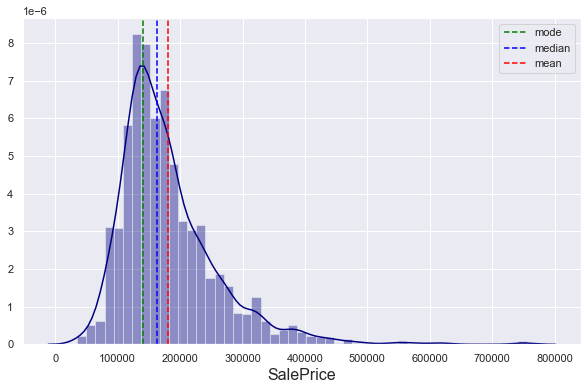

In [30]:
sigma = train_df.SalePrice.std()
mu = train_df.SalePrice.mean()
med = train_df.SalePrice.median()
mode = train_df.SalePrice.mode().to_numpy()

sns.distplot(train_df.SalePrice)
plt.axvline(mode, linestyle='--', color='green', label='mode')
plt.axvline(med, linestyle='--', color='blue', label='median')
plt.axvline(mu, linestyle='--', color='red', label='mean')
plt.legend()

Our response variable appears to be right skewed, so is a candidate for log transformation. Below we see that log(y+1) provides a nice distribution. We will keep this distribution in mind for use in a `TransformedTargetRegressor` when it is time to make predictions.

testing a log transformation supplies a much more normal distribution:

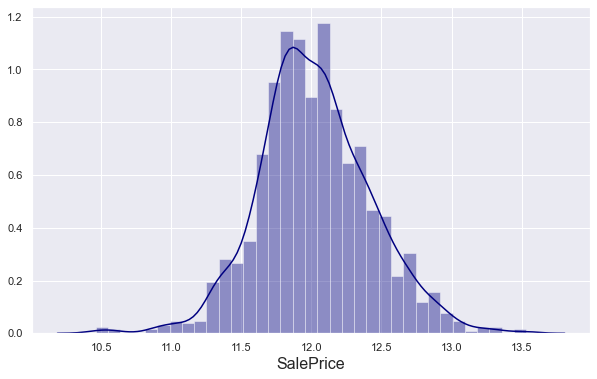

In [4]:
sns.distplot(np.log1p(train_df.SalePrice), kde=True)

Let's get warmed up with a check our intuition that it's not just quantity but quality that counts toward final sale price:

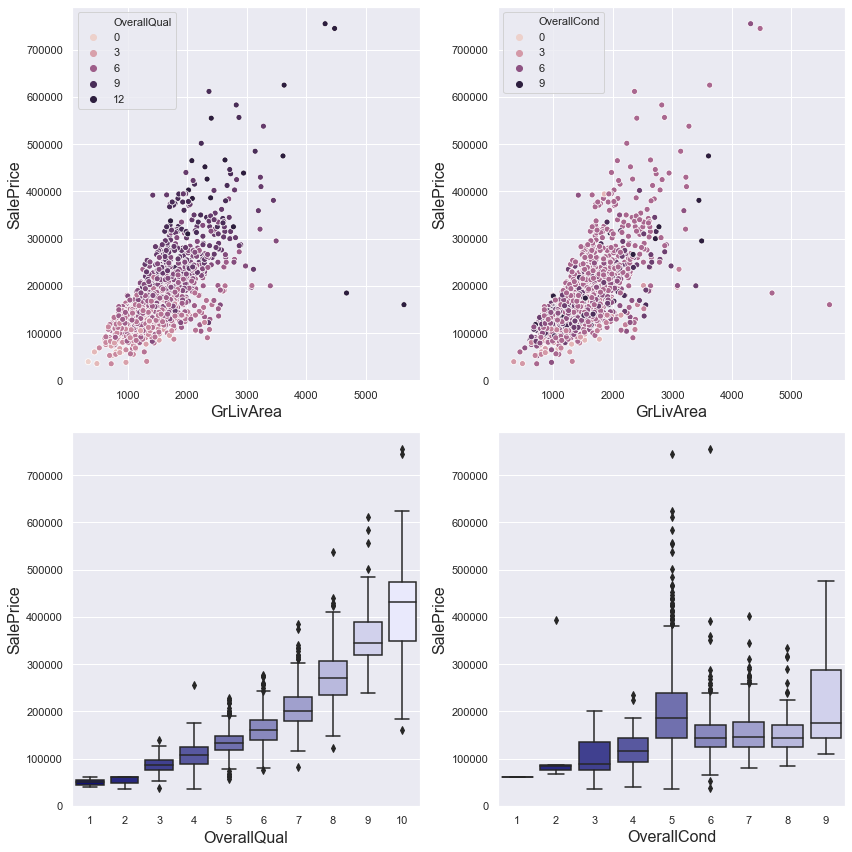

In [5]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data=train_df, ax=axes[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallCond', data=train_df, ax=axes[0,1])
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, ax=axes[1,0])
sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, ax=axes[1,1])
plt.tight_layout()

It appears that sale price is graduated not only by above ground living area but also by quality of material and finish (described by __OverallQual__). Surprisingly, it appears that overall condition (__OverallCond__) is rather well mixed. The box plots show negative skew (towards smaller area) in below average condition homes and positive skew (towards larger) in above average condition homes, but nothing to write home about. 

Also notice the two outliers, homes with relatively large square footage, plus high quality materials, above average condition which sold ___well___ below average. We will likely discount these outliers for purposes of making predictions.

Next we will run through some of the other most intuitive predictors of home sale prices, looking for correlation to our response variable (sale price). We will use both standard univariate correlation now, and later post-hoc residual plots to test our assumptions of linearity. In order to perform statistical modeling, we need to convert our categorical data to numbers first. The variables I believe intuitively add to sale prices are:

In [6]:
# a selection of variables that I expect to add to home value and/or curbside appeal, by variable type
exp_ordinal = ['ExterQual', 'ExterCond', 'Functional', 'OverallQual', 'OverallCond', 'BsmtCond', 'GarageCars']
exp_nominal = ['Neighborhood', 'MSZoning', 'Condition1', 'Condition2', 'GarageCars']
exp_contin  = ['LotArea', 'GrLivArea', 'GarageArea']

Almost all "Quality and Condition" variables share the same letter code scheme in the data: 

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Some variables like __BsmtCond__ (Basement Condition) have an additional category (NA - No Basement). We will encode these as integers from 0 to 5.

In [7]:
qual_map = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 
             'BsmtCond', 'HeatingQC', 'KitchenQual', 
             'FireplaceQu', 'GarageQual', 'GarageCond',
             'PoolQC']

for col in qual_vars:
    train_df[col] = train_df[col].map(qual_map)
    
train_df[qual_vars]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4,3,4.0,3.0,5,4,NaN,3.0,3.0,NaN
2,3,3,4.0,3.0,5,3,3.0,3.0,3.0,NaN
3,4,3,4.0,3.0,5,4,3.0,3.0,3.0,NaN
4,3,3,3.0,4.0,4,4,4.0,3.0,3.0,NaN
5,4,3,4.0,3.0,5,4,3.0,3.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1456,3,3,4.0,3.0,5,3,3.0,3.0,3.0,NaN
1457,3,3,4.0,3.0,3,3,3.0,3.0,3.0,NaN
1458,5,4,3.0,4.0,5,4,4.0,3.0,3.0,NaN


The __Functional__ variable, which outlines major deductions or damage might be good to inspect, so we will encode it as a ordinal variable.

In [28]:
func_map = {
    'Sal':  1,
    'Sev':  2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod':  5,
    'Min2': 6,
    'Min1': 7,
    'Typ':  8
}

train_df['Functional'] = train_df.Functional.map(func_map)

Now, we must consider the association between our predictor variables and our response variable. Because we are dealing with a continuous response variable, but have some categorical features, we will have to think carefully about how to measure association. For the ordinal data, I propose either using Kendall's $\tau$ or descritizing sale prices and using Goodman and Kruskal's $\gamma$. Since Kendall's $\tau$ is included in the scikit learn library, we need not write our own method. 

In [11]:
# exp_ordinal.append('SalePrice'),
# exp_contin.append('SalePrice')

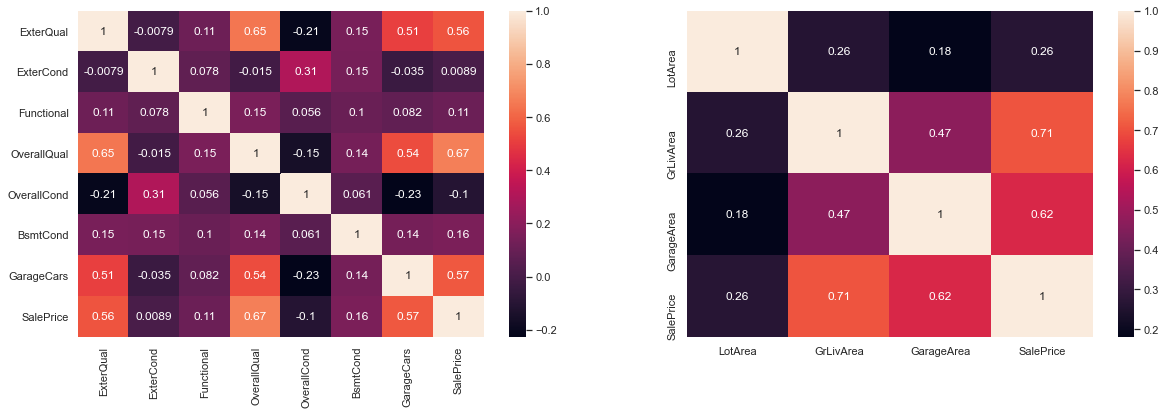

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

sns.heatmap(train_df[exp_ordinal+['SalePrice']].corr(method='kendall'), annot=True, ax=axes[0])
sns.heatmap(train_df[exp_contin+['SalePrice']].corr(), annot=True, ax=axes[1])

In [25]:
def plot_response_corr(df, features, response, corr_type):
    
    cor = pd.DataFrame()
    
    # Measure difference between Spearman's and Pearson's to analyze for non-linearity
    if corr_type == 's-p':
        
        cor['feature'] = features
        cor['spearman'] = [df[f].corr(df[response], 'spearman') for f in features]
        cor['pearson'] = [df[f].corr(df[response], 'pearson') for f in features]
        cor['comparison'] = cor['spearman'] - cor['pearson']
        
        
        fig, axes = plt.subplots(3,1, sharex=True, figsize=(len(cor.feature)*1.5, 10))

        sns.barplot(data=cor.sort_values('comparison'), x='feature', y='comparison', ax=axes[2]) \
            .set_title('S-P comparison to response variable')

        sns.barplot(data=cor.sort_values('spearman'), x='feature', y='spearman', ax=axes[1]) \
            .set_title('Spearman association to response variable')

        sns.barplot(data=cor.sort_values('pearson'), x='feature', y='pearson', ax=axes[0]) \
            .set_title('Pearson association to response variable')
        
    else:
        cor['feature'] = features
        cor[corr_type] = [df[f].corr(df[response], corr_type) for f in features]
        cor = cor.sort_values(corr_type)
        plt.figure(figsize=(len(features)*1.5, 5))
        axes = sns.barplot(data=cor, x='feature', y=corr_type) \
            .set_title(f'{corr_type} association to response variable')
        
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df 

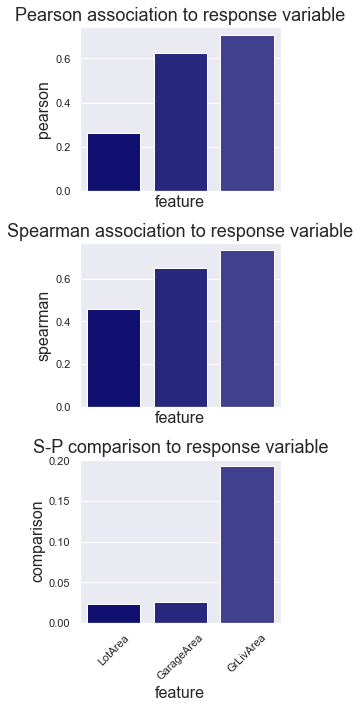

In [26]:
df = plot_response_corr(train_df, exp_contin, 'SalePrice', 's-p')

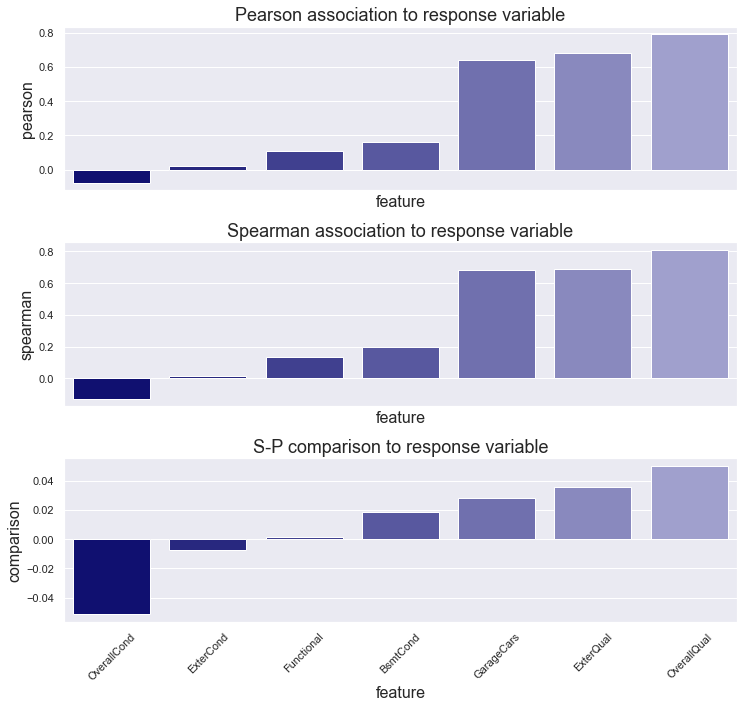

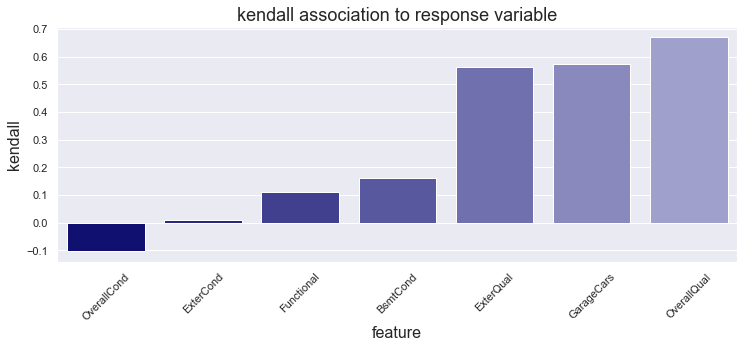

In [27]:
df = plot_response_corr(train_df, exp_ordinal, 'SalePrice', 's-p')
df = plot_response_corr(train_df, exp_ordinal, 'SalePrice', 'kendall')

## Summary of Visualizations:

The above is a lot to look at. Maybe I should intersperse the breakdown with the graphs. I welcome feedback here. For now, I will break down the graphs in two parts: continuous and categorical.

### Continuous Data

There is moderate to high correlation between sale price and the features describing lot size, above ground living area and garage size. Additionally, while the association appears to be linear in above grade living area and garage area. However, there is some indication of a non-linear relationship between lot area and sale price. It might be worth investigating, and is an indicator that the data needs to be transformed before applying machine learning. 

### Categorical Data

Most of our intuitions proved to be at least somewhat correct. 

A couple notable exceptions are the low association between __SalePrice__ and __ExterCond__, which was unexpected.

Additionally, there is an inverse association with __OverallCond__. This seems to indicate that better overall condition of a home negatively impacts sale price. In my mind, there are a couple possible explanations:
- First, perhaps the variable is encoded such that higher numbers mean worse condition. (On looking at the encoding, this is not the case
- Second, correlation/association at a univariate level is not necessarily an indicator of association when there are more variables or higher dimensions to the data. With almost 80 variables at play, this is a possibility. 

### Sale Price Relationship With Nominal Data

For our nominal data, quantitative association is somewhat difficult to achieve in the same way as ordinal and continuous data. We can, however take a look at box our violin plots for each of our interesting nominal variables. The idea is to look for separation of home values according to category. We are graphically answering questions like _"Is the average cost of a home significantly different between neighborhoods X, Y, and Z?"_.

To refresh our memories on what our nominal variables are:

- __Neighborhood__
- __MSZoning__
- __Condition1 & Condition2__


### Neighborhood:

In [140]:
# for ordering the boxplots by median
grouped = train_df.loc[:,['Neighborhood', 'SalePrice']] \
    .groupby(['Neighborhood']) \
    .mean() \
    .sort_values(by='SalePrice')

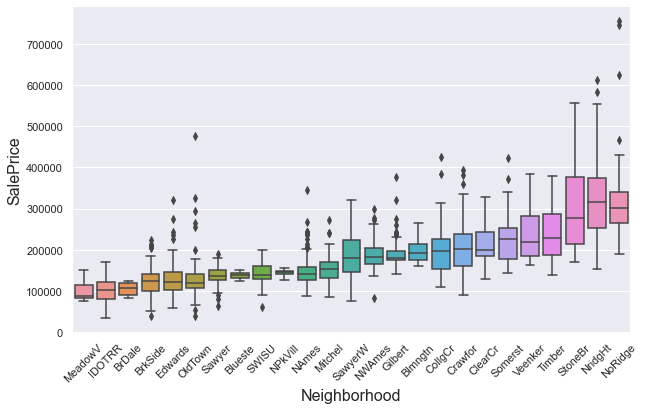

In [141]:
chart = sns.boxplot(x=train_df.Neighborhood, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

It appears that we can order neighborhoods by their median home value. We will perform one way ANOVA on the data to see if this difference is significant.  It remains to be seen how much weight the adage "location, location, location" carries real weight.

### Zoning

Our data dictionary defines __MSZoning__ as _"Identifies the general zoning classification of the sale."_, with the following possible categories:

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

We will apply the same techniques as before to see if we can rank these zones by their average home value.

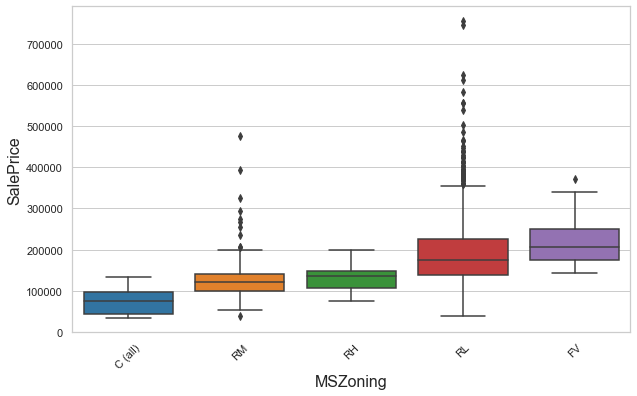

In [16]:
grouped = train_df.loc[:,['MSZoning', 'SalePrice']] \
    .groupby(['MSZoning']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.MSZoning, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

As before, there is visually some separation between the means. We will add it to the 'to-do ANOVA' list.

## Proximity to Urban Features

The __Condition1 & Condition2__ variables describe proximity to the following features such as parks, railroads, etc:

       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

We will see if we can rank these features as before, but this time we will rank both individual features and every combination of two. 

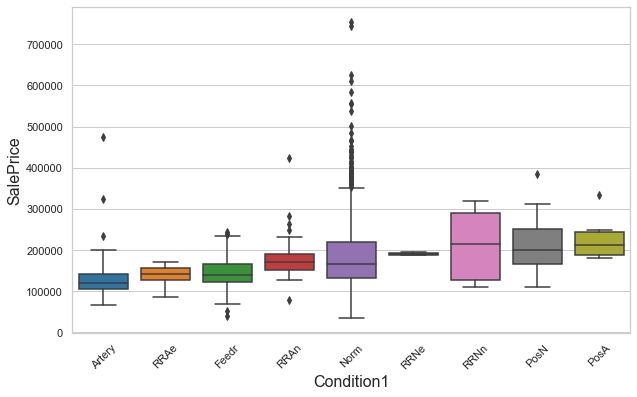

In [17]:
grouped = train_df.loc[:,['Condition1', 'SalePrice']] \
    .groupby(['Condition1']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.Condition1, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

This one doesn't look as promising to me. Again, only a test will tell. Let's go ahead and run such a test on all of these questionable categories.

91

In [125]:
def anova(df, predictor, target, alpha=0.05):
    
    # get unique, indendant treatments (categories in predictory)
    treatments = df[predictor].unique()
    group_values = []
    
    # group target variable by category
    for t in treatments:
        group_values.append(df.loc[df[predictor] == t, target].to_numpy())
    
    # calculate degrees of freedom and confidence interval
    k = len(treatments)
    n = df[predictor].notnull().sum()
    conf = 1 - alpha
    df1 = k - 1
    df2 = n - k
    
    # calculate critical value of F-distribution
    crit_val = stats.f.ppf(conf, df1, df2)
    
    # calculate F and p
    f, p = stats.f_oneway(*group_values)
    
    return f, p, crit_val

In [126]:
for var in exp_nominal:
    print(var)
    print(anova(train_df, var, 'SalePrice'))

Neighborhood
(71.78486512058272, 1.558600282771154e-225, 1.5249128061134027)
MSZoning
(43.84028167245718, 8.817633866272648e-35, 2.3780442396567194)
Condition1
(6.118017137125925, 8.904549416138853e-08, 1.944772855332636)
Condition2
(2.0738986215227877, 0.043425658360948464, 2.0158744914180047)
GarageCars
(351.2074862087728, 1.1211287650612485e-211, 2.3780442396567194)


__FireplaceQu__ (Fireplace Quality) is the first variable with less than 50 percent missing data. The __Fireplaces__ (# of fireplaces variable)  has a possible value of "NA - No Fireplace". Perhaps these entries are associated with the missing data in the quality description.

In [19]:
nofire_na = train_df.loc[train_df.FireplaceQu.isna() &
                         (train_df.Fireplaces == 0)].shape[0]

In [20]:
train_df.FireplaceQu.isna().sum(), nofire_na

(690, 690)

So indeed, all 690 instances of missing data in __FireplaceQu__ are associated with homes that don't have fireplaces. According to the variable description, these values should be "NA" not "NaN". We will fix that now:

In [21]:
train_df.loc[train_df.FireplaceQu.isnull(), 'FireplaceQu'] = 'NA'

In [22]:
(train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending=False).head(10)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
LotFrontage     0.177397
GarageType      0.055479
GarageQual      0.055479
GarageCond      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64

Next, we will encode the nominal variables we wish to inspect:

In [9]:
train_df[exp_nominal]

,Neighborhood,MSZoning,Condition1,Condition2,GarageCars
Id,,,,,
1,CollgCr,RL,Norm,Norm,2
2,Veenker,RL,Feedr,Norm,2
3,CollgCr,RL,Norm,Norm,2
4,Crawfor,RL,Norm,Norm,3
5,NoRidge,RL,Norm,Norm,3
...,...,...,...,...,...
1456,Gilbert,RL,Norm,Norm,2
1457,NWAmes,RL,Norm,Norm,2
1458,Crawfor,RL,Norm,Norm,1


In [10]:
# for var in exp_nominal:
#     train_df[var], _ = pd.factorize(train_df[var])